# Text Classification

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-txt-classification/sample_submission.csv
/kaggle/input/nlp-txt-classification/train.csv
/kaggle/input/nlp-txt-classification/test.csv


In [62]:
from pathlib import Path
from typing import List, Dict, Any

import torch
from torch import nn
from torch.optim import Adam

from transformers import BertTokenizer
from transformers import BertModel

from tqdm import tqdm

In [4]:
DATA_PATH = Path('/kaggle/input/nlp-txt-classification')

SEED = 42
NUM_CLASSES = 5

BATCH_SIZE = 64

In [7]:
df_test = pd.read_csv(DATA_PATH / 'test.csv')
df_test.head(10)

,id,Text
0,787bc85b-20d4-46d8-84a0-562a2527f684,TRENDING: New Yorkers encounter empty supermar...
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,When I couldn't find hand sanitizer at Fred Me...
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Find out how you can protect yourself and love...
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,#Panic buying hits #NewYork City as anxious sh...
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,#toiletpaper #dunnypaper #coronavirus #coronav...
5,b130f7fb-7048-48e6-a8af-57bb56ac1e27,Do you remember the last time you paid $2.99 a...
6,db72c632-8719-4847-b7f2-a89af05e1504,Voting in the age of #coronavirus = hand sanit...
7,e45239d8-4dcf-4685-a955-a9a08ca829ee,"@DrTedros ""We canÂt stop #COVID19 without pro..."
8,2854b1b2-5a41-4002-90d3-17fe77a3a78e,HI TWITTER! I am a pharmacist. I sell hand san...
9,ff9be7e1-81a9-4c07-beda-4fee9a923f5e,Anyone been in a supermarket over the last few...


In [24]:
df = pd.read_csv(DATA_PATH / 'train.csv')
df = df[['Text', 'Sentiment']].dropna()
df.head(10)

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,As news of the regionÂs first confirmed COVID...,Positive
6,Cashier at grocery store was sharing his insig...,Positive
7,Was at the supermarket today. Didn't buy toile...,Neutral
8,Due to COVID-19 our retail store and classroom...,Positive
9,"For corona prevention,we should stop to buy th...",Negative


In [25]:
df['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

<AxesSubplot:xlabel='Sentiment'>

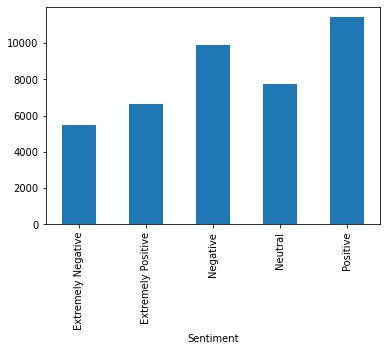

In [26]:
df.groupby(['Sentiment']).size().plot.bar()

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {
    'Extremely Negative': 0,
    'Negative': 1,
    'Neutral': 2,
    'Positive': 3,
    'Extremely Positive': 4,
}

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [
            labels[label]
            for label in df['Sentiment']
        ]
        self.texts = [
            tokenizer(
                text, 
                padding='max_length',
                max_length = 512,
                truncation=True,
                return_tensors="pt",
            )
            for text in df['Text']
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [31]:
np.random.seed(112)
df_train, df_val = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df))])

print(len(df_train), len(df_val))

32924 8231


In [32]:
class BertClassifier(nn.Module):
    def __init__(self, num_classes:int, dropout:int=0.5):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, num_classes)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [37]:
def train(model, train_data, val_data, learning_rate, epochs):
    train = Dataset(train_data)
    val = Dataset(val_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        print(' | '.join([
            f'Epochs: {epoch_num + 1}',
            f'Train Loss: {total_loss_train / len(train_data):.3f}',
            f'Train Accuracy: {total_acc_train / len(train_data):.3f}',
            f'Val Loss: {total_loss_val / len(val_data):.3f}',
            f'Val Accuracy: {total_acc_val / len(val_data):.3f}',
        ]))

In [41]:
model = BertClassifier(num_classes=len(labels.keys()))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
EPOCHS = 1
LR = 1e-6

train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 16462/16462 [37:30<00:00,  7.31it/s]


Epochs: 1 | Train Loss: 0.674 | Train Accuracy: 0.413 | Val Loss: 0.517 | Val Accuracy: 0.571


In [43]:
EPOCHS = 2
LR = 1e-6

train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 16462/16462 [37:31<00:00,  7.31it/s]


Epochs: 1 | Train Loss: 0.431 | Train Accuracy: 0.668 | Val Loss: 0.388 | Val Accuracy: 0.707


100%|██████████| 16462/16462 [37:31<00:00,  7.31it/s]


Epochs: 2 | Train Loss: 0.313 | Train Accuracy: 0.773 | Val Loss: 0.351 | Val Accuracy: 0.741


In [63]:
def flip_dict(x: Dict[Any, Any]) -> Dict[Any, Any]:
    return dict([
        (v, k)
        for k, v in x.items()
    ])

In [81]:
def predict(model, text: str, labels: Dict[int, str]):
    t = tokenizer(
        text, 
        padding='max_length',
        max_length = 512,
        truncation=True,
        return_tensors="pt",
    )
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model = model.cuda()
    with torch.no_grad():
        mask = t['attention_mask'].to(device)
        input_id = t['input_ids'].squeeze(1).to(device)
        output = model(input_id, mask)
        pred = output.cpu().numpy()
        idx = np.argmax(pred)
        return labels[idx]

In [72]:
x = df_test.loc[1, 'Text']

pred = predict(model, x, labels=flip_dict(labels))

print(x)
pred

When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how  #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY


'Positive'

In [76]:
pred_labels = flip_dict(labels)

df_test['Sentiment'] = df_test['Text'].apply(lambda text: predict(model, text, labels=pred_labels))
df_test.head(10)

,id,Text,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,When I couldn't find hand sanitizer at Fred Me...,Positive
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Find out how you can protect yourself and love...,Extremely Positive
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,#Panic buying hits #NewYork City as anxious sh...,Negative
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
5,b130f7fb-7048-48e6-a8af-57bb56ac1e27,Do you remember the last time you paid $2.99 a...,Neutral
6,db72c632-8719-4847-b7f2-a89af05e1504,Voting in the age of #coronavirus = hand sanit...,Positive
7,e45239d8-4dcf-4685-a955-a9a08ca829ee,"@DrTedros ""We canÂt stop #COVID19 without pro...",Positive
8,2854b1b2-5a41-4002-90d3-17fe77a3a78e,HI TWITTER! I am a pharmacist. I sell hand san...,Extremely Negative
9,ff9be7e1-81a9-4c07-beda-4fee9a923f5e,Anyone been in a supermarket over the last few...,Extremely Positive


In [80]:
submission = df_test[['id', 'Sentiment']]
submission.to_csv('submission.csv', index=False)